# CIFAR10 Training and quantization

Project inspired by this [kaggle competition](https://www.kaggle.com/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy#A-Simple-Keras-CNN-trained-on-CIFAR-10-dataset-with-over-88%-accuracy-(Without-Data-Augmentation). In this colab you will be driven through the training of a CNN for CIFAR10 classification task. The model is then exported for inference with tflite and quantized, prepared for the *GAPflow*.

### Used python modules

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
from PIL import Image

In [2]:
import tensorflow as tf
tf.__version__, tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.7.0', False)

# Reading the CIFAR-10 dataset from Keras datasets

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [4]:
# Checking the number of rows (records) and columns (features)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
# Checking the number of unique classes 
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [6]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

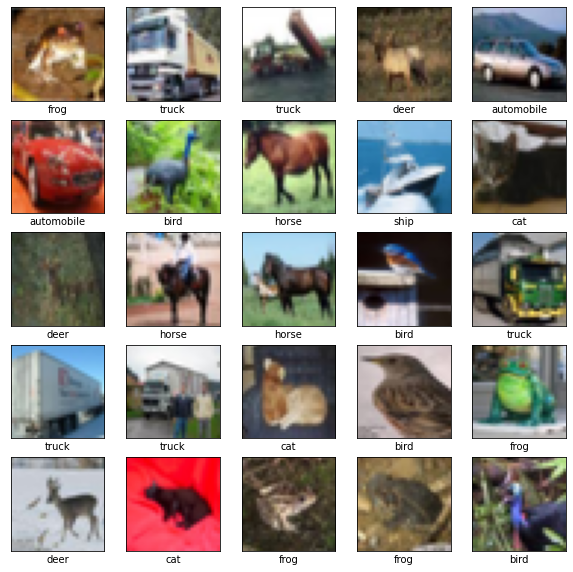

In [7]:
# Visualizing some of the images from the training dataset
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])

plt.show()

# Data Preprocessing

Convert input [0:255] to [-1:1] float

Convert labels to one hot encoding

In [8]:
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
 
# Standardizing (255 is the total number of pixels an image can have)
train_images = (train_images / 128) - 1.0
test_images = (test_images / 128) - 1.0

# One hot encoding the target class (labels)
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [9]:
# Creating a sequential model and adding layers to it
model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(32, (3,3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(64, (3,3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(128, (3,3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

# Checking the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 32)        0

# Compile and Train the model (or load the pretrained one)

In [27]:
#checkpoint_path = "gdrive/MyDrive/cifar10/saved_model/my_model"
checkpoint_path = "./model/saved_model/"
train_again = False

if os.path.exists(checkpoint_path) and not train_again:
  model = tf.keras.models.load_model('model/saved_model/my_model')
  history = None
else:
  model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  history = model.fit(train_images, train_labels, batch_size=64, epochs=10, # Add more epochs to get better results
                      validation_data=(test_images, test_labels))

# Making the Predictions
pred = model.predict(test_images)
accuracy = 100 * np.sum(np.argmax(pred, 1) == np.argmax(test_labels, 1)) / len(test_labels)
print(f"Trained model Accuracy: {accuracy}%")

Trained model Accuracy: 78.73%


# Visualize training results

Only available if you have trained the model in this session

In [11]:
if history:
  # Loss curve
  plt.figure(figsize=[6,4])
  plt.plot(history.history['loss'], 'black', linewidth=2.0)
  plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
  plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
  plt.xlabel('Epochs', fontsize=10)
  plt.ylabel('Loss', fontsize=10)
  plt.title('Loss Curves', fontsize=12)

In [12]:
if history:
  # Accuracy curve
  plt.figure(figsize=[6,4])
  plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
  plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
  plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
  plt.xlabel('Epochs', fontsize=10)
  plt.ylabel('Accuracy', fontsize=10)
  plt.title('Accuracy Curves', fontsize=12)

# See the model at work

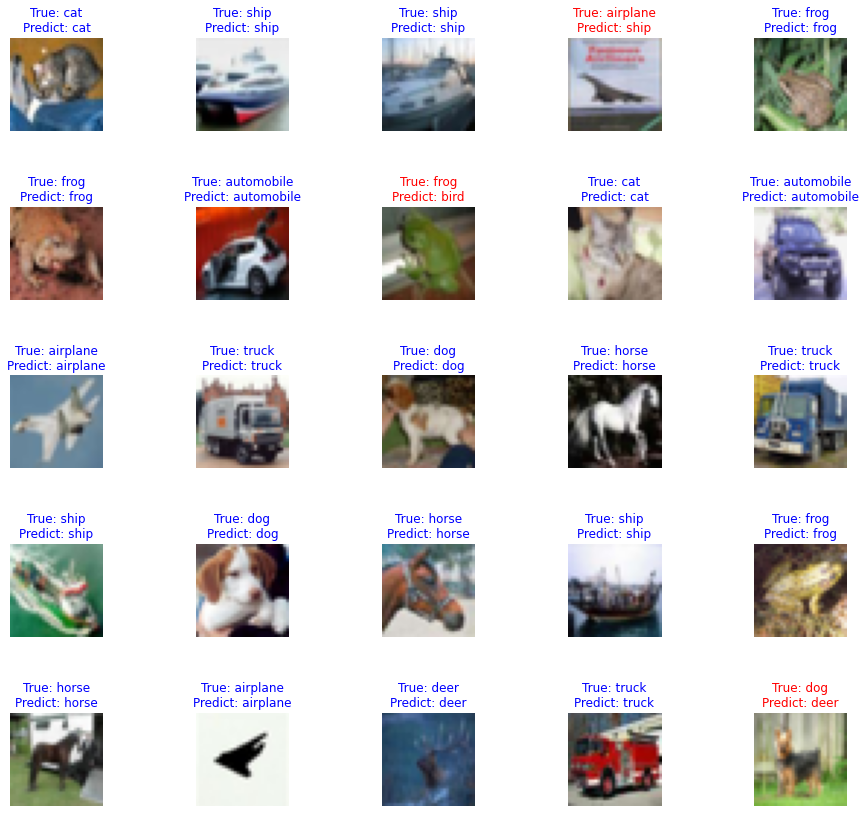

In [28]:
# Plotting the Actual vs. Predicted results
# Converting the predictions into label index 
pred_classes = np.argmax(pred, axis=1)

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow((128*(test_images[i]+1)).astype(np.uint8))
    axes[i].set_title(f"True: {class_names[np.argmax(test_labels[i])]}\nPredict: {class_names[pred_classes[i]]}", color="r" if class_names[np.argmax(test_labels[i])]!=class_names[pred_classes[i]] else "b")
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)
    img = Image.fromarray(np.uint8(128*(test_images[i]+1)))
    img.save(f"samples/cifar_test_{i}_{np.argmax(test_labels[i])}.ppm")


# Convert to tflite

In [30]:
from tqdm import tqdm
# Helper function to run inference on a TFLite model
def test_tflite_model(tflite_file, test_images, test_labels):
  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_images),), dtype=int)
  for i, (test_image, test_label) in tqdm(enumerate(zip(test_images, test_labels))):
    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  test_labels_not_one_hot = np.argmax(test_labels, 1)
  accuracy = (np.sum(test_labels_not_one_hot == predictions) * 100) / len(test_images)
  return accuracy

In [31]:
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the unquantized/float model:
tflite_model_file = pathlib.Path("model/cifar10_model_fp32.tflite")
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpjcwp8hh0/assets


2208784

In [32]:
fp32_accuracy = test_tflite_model(tflite_model_file, test_images, test_labels)
print(f"\nFloat model accuracy: {fp32_accuracy}")

10000it [00:30, 331.17it/s]


Float model accuracy: 78.73


## Quantize to int8

We use post training integer quantization to quantize the model (https://www.tensorflow.org/lite/performance/post_training_integer_quant).

Weights are quantized directly from their values (they are constants), activations on the other hand depend on the input data. Hence we need to provide a calibration dataset to the quantizer so that it can run inference on it and collect the statistics of each layer in order to quantize the values in those ranges, i.e. Layer1 -> [-3.0, 6.0], Layer2 -> [-1.0, 2.5], ...

As calibration dataset we need representative data of our use case. They cannot be the testing set, we are "learning" the statistics so using test dataset would be cheating. A subset of the training is tipycally used.

In [35]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

# Save the unquantized/float model:
tflite_quant_model_file = pathlib.Path("model/cifar10_model_uint8.tflite")
tflite_quant_model_file.write_bytes(tflite_model_quant)

INFO:tensorflow:Assets written to: /tmp/tmpbg8v5nt9/assets


INFO:tensorflow:Assets written to: /tmp/tmpbg8v5nt9/assets


570872

In [36]:
quant_accuracy = test_tflite_model(tflite_quant_model_file, test_images[:1000], test_labels[:1000])
print(f"Quantized model accuracy: {quant_accuracy}")

1000it [01:33, 10.65it/s]

Quantized model accuracy: 77.7
